In [1]:
# Imports
import pandas as pd
import numpy as np
import re
import nltk
import time
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

!pip install gensim
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
# Load dataset
df = pd.read_csv('/content/Reviews.csv', on_bad_lines='warn', engine='python')
df = df[['Text', 'Score']].dropna()
df = df[df['Score'] != 3]  # Remove neutral reviews
df['label'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

<ipython-input-2-598e98a26001>:2: ParserWarning: Skipping line 287497: unexpected end of data

  df = pd.read_csv('/content/Reviews.csv', on_bad_lines='warn', engine='python')


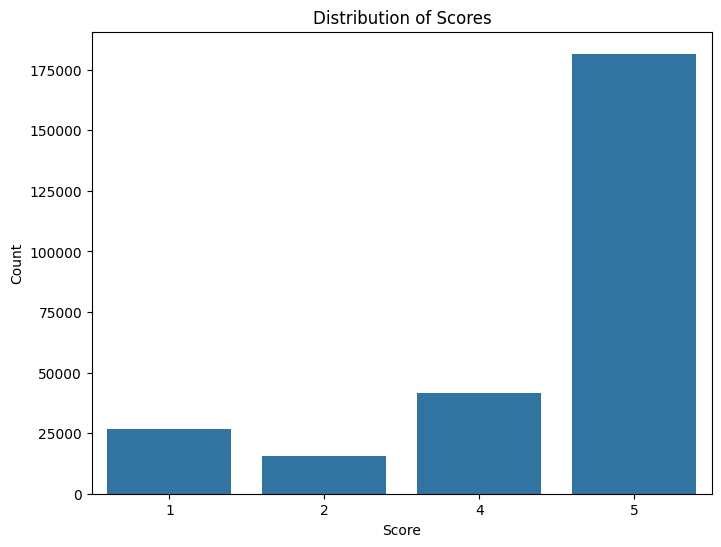

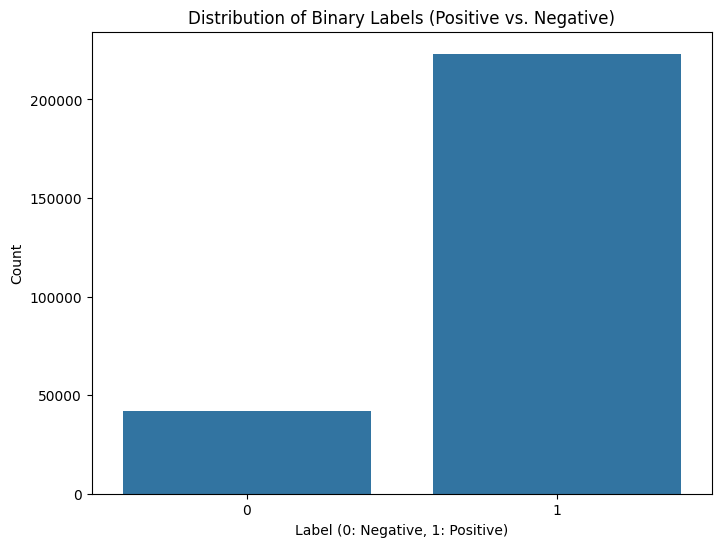

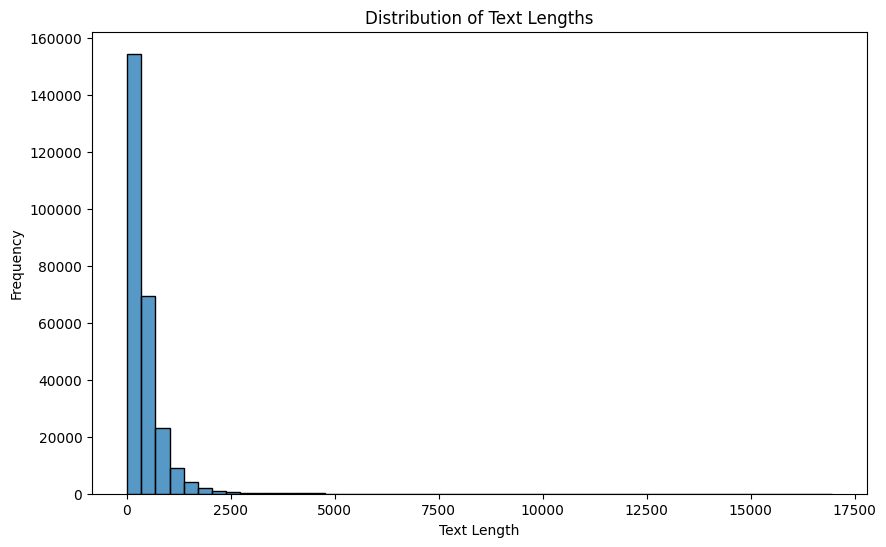

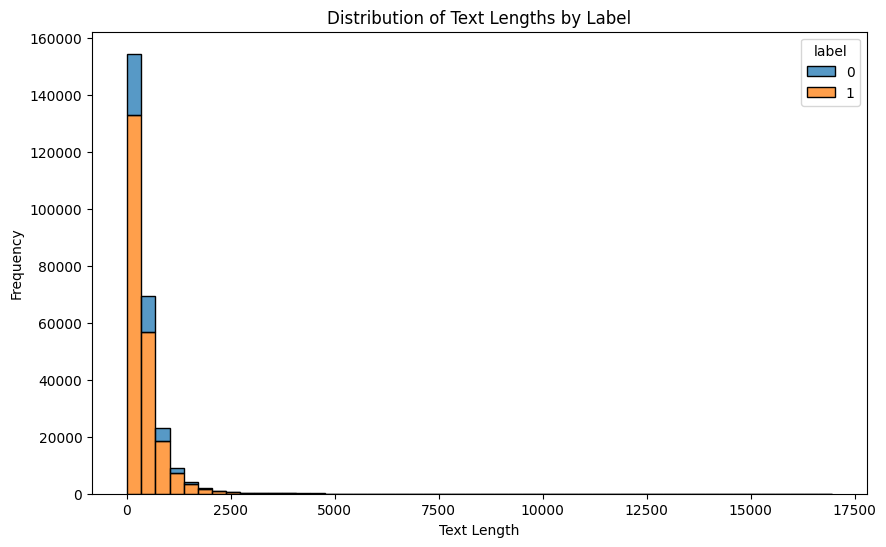

In [3]:
import matplotlib.pyplot as plt
# Check the distribution of scores
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Score')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

# Check the distribution of the new binary label
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label')
plt.title('Distribution of Binary Labels (Positive vs. Negative)')
plt.xlabel('Label (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.show()

# Distribution of review length
df['text_length'] = df['Text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', bins=50)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Distribution of text length by label
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='label', bins=50, multiple="stack")
plt.title('Distribution of Text Lengths by Label')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [4]:
# using 10000 review for model training and evaluation
df = df.sample(10000)

In [6]:
# Text Cleaning Function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_text'] = df['Text'].astype(str).apply(clean_text)

In [7]:
df.head()

,Text,Score,label,text_length,cleaned_text
50242,"Big bag of fresh, unsalted macadamia nuts. Nic...",5,1,131,big bag fresh unsalted macadamia nut nicest on...
157409,I eat well. I read a lot of research on health...,5,1,2183,eat well read lot research health medline junk...
130595,I enjoyed this coffee. Good flavor. Reasonable...,4,1,130,enjoyed coffee good flavor reasonable priced w...
92503,"My favorite for ""toasted"" flavor. When I ran ...",5,1,546,favorite toasted flavor ran brand recently fri...
141192,I rotate this dish with other Elegant Medley's...,4,1,543,rotate dish elegant medley salmon version like...


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=5000)
x = vectorizer.fit_transform(df['cleaned_text']).toarray()
y = df['label'].values

x = x.reshape((x.shape[0], 1, x.shape[1]))

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state=42)

**LSTM Model with BoW Input**

In [22]:
model = Sequential()
model.add(LSTM(64, input_shape=(x.shape[1], x.shape[2])))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

start_time = time.time()
history = model.fit(x_train, y_train, epochs=2, batch_size=128, validation_data = (x_test, y_test))
training_time = time.time() - start_time
print(f"Training time: {training_time} seconds")

# Evaluate the model
start_time = time.time()
# Reshape x_test to match the expected input shape of the LSTM layer
x_test_reshaped = x_test.reshape((x_test.shape[0], 1, x_test.shape[2]))
y_pred = (model.predict(x_test_reshaped) > 0.5).astype("int32")
testing_time = time.time() - start_time


# Metrics
from sklearn.metrics import classification_report
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Training Time:", training_time)
print("Testing Time:", testing_time)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.8342 - loss: 0.5419 - val_accuracy: 0.8500 - val_loss: 0.3798
Epoch 2/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8493 - loss: 0.3336 - val_accuracy: 0.8825 - val_loss: 0.2937
Training time: 10.657495975494385 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy: 0.8825
Training Time: 10.657495975494385
Testing Time: 0.8924007415771484

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.25      0.39       301
           1       0.88      0.99      0.93      1699

    accuracy                           0.88      2000
   macro avg       0.89      0.62      0.66      2000
weighted avg       0.88      0.88      0.85      2000



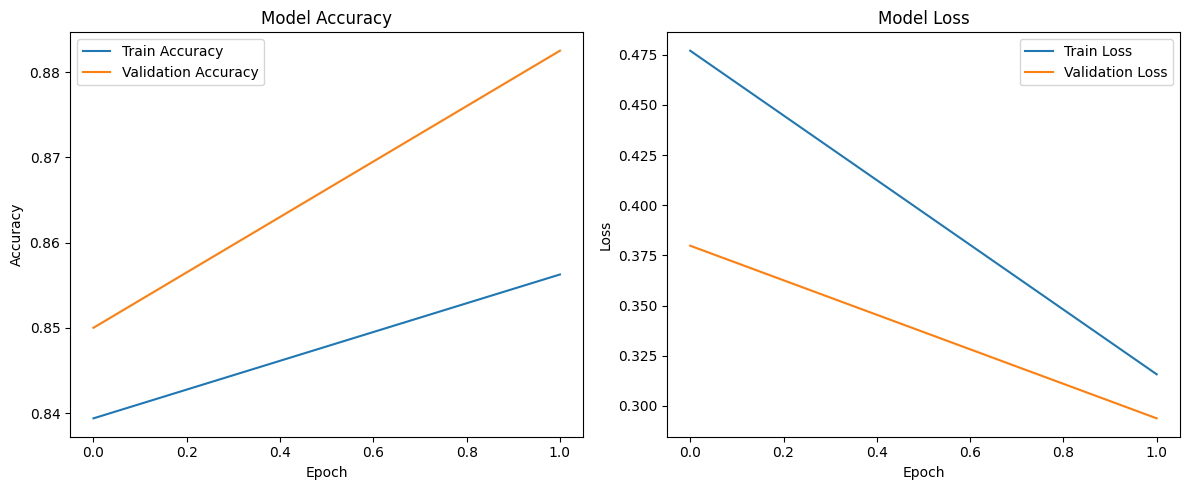

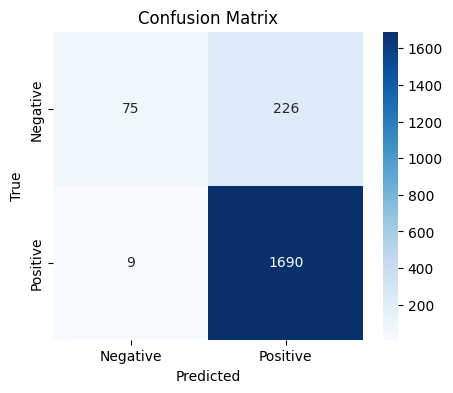

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Accuracy and Loss Plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
